
## Notes from: 2022-05-30


- ~~Understand trainable parameters~~

- ~~Check diff between probability densities computed each time from native and regular grid~~ 

- ~~Compute geo and check rmse between vel and vel_geo (rmse)~~

- ~~Learn from (u,v)_geo~~

 





In [5]:
import matplotlib.pyplot as plt
import numpy as np                                                                                                                                                                                  
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.reset_defaults()
sns.set_context("talk", font_scale=0.8)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Quantify error magnitude while using regular grid instead of native one:


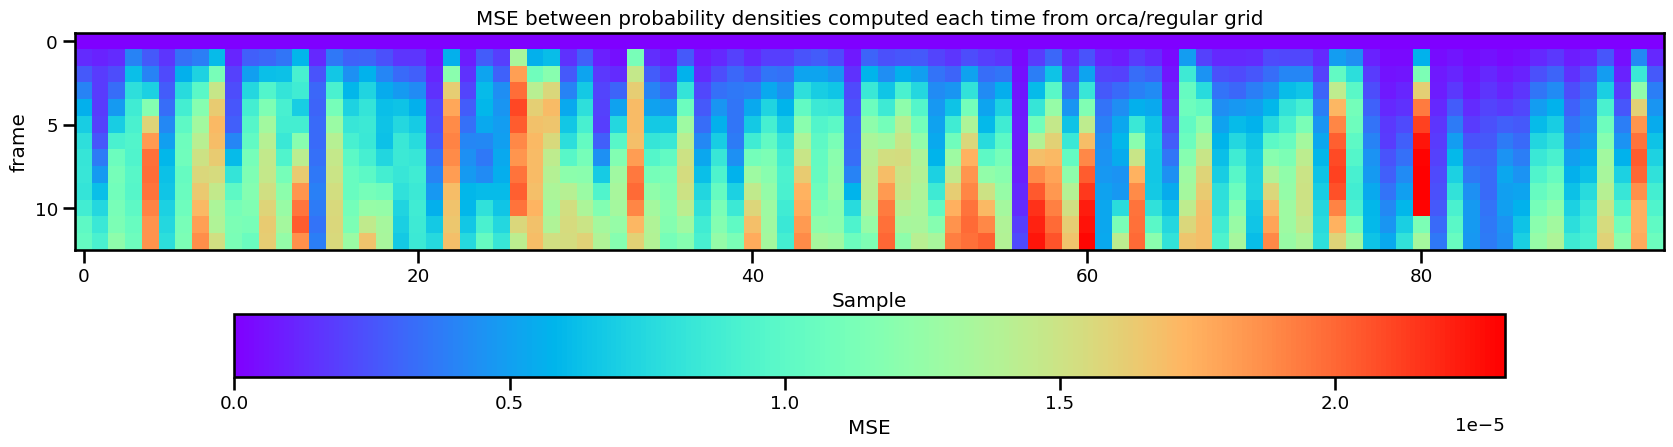

In [4]:
import numpy as np                                                                                                                                                                                  
import xarray as xr                                                                                                                                                                                 
import os                                                                                                                                                                                           
import matplotlib.pyplot as plt                                                                                                                                                                     
import matplotlib.cm as cm                                                                                                                                                                          
                                                                                                                                                                                                    
                                                                                                                                                                                                    
def rmse(y1, y2):                                                                                                                                                                                   
    return np.sqrt(((y1-y2)**2)).mean()                                                                                                                                                             
                                                                                                                                                                                                    
                                                                                                                                                                                                    
rpath='~/MEOM_Workspace/data/raw/cook_coordinate/real/density_maps/'                                                                                                                                                                          
nrpath='~/MEOM_Workspace/data/raw/cook_coordinate/nreal/density_maps/'                                                                                                                                                                        
err=np.zeros((13, 95))                                                                                                                                                                              
for i in range(95):                                                                                                                                                                                 
    #print(rpath + str(i)+'.nc')                                                                                                                                                                     
    rx=xr.open_dataset(rpath + str(i)+'.nc').density_map.data                                                                                                                                       
    nrx=xr.open_dataset(nrpath + str(i)+'.nc').density_map.data                                                                                                                                     
    for j in range(13):                                                                                                                                                                             
        aa=rmse(rx[-1][j],nrx[-1][j])                                                                                                                                                               
        err[j,i]=aa                                                                                                                                                                                 
        #print(aa)                                                                                                                                                                                   
                                                                                                                                                                                                    
                                                                                                                                                                                                    
                                                                                                                                                                                                    
plt.rcParams["figure.figsize"] = [20.50, 5.50]
plt.imshow(err, cmap=cm.rainbow)   
plt.xlabel('Sample')
plt.ylabel('frame')
plt.title('MSE between probability densities computed each time from orca/regular grid')

cbar=plt.colorbar(label="MSE", orientation="horizontal")
plt.show()

## Compare current and geostrophic current  


In [5]:
from pathlib import Path

pathlist = Path('/home/anas/MEOM_Workspace/data/raw/Geo_curr/').glob('*gridU-2D.nc')
pathlist =sorted(pathlist)
u_err=np.zeros((1092))
j=0

for path in pathlist:
    u=xr.open_dataset(path).sozocrtx.data
    ug=xr.open_dataset(path).vozocrtx.data
    u[np.isnan(ug)] = 0
    ug[np.isnan(ug)] = 0
    for i in range(4):
        u_err[j]=rmse(u[i,:,:],ug[i,:,:]) 
        j=j+1

        
pathlist = Path('/home/anas/MEOM_Workspace/data/raw/Geo_curr/').glob('*gridV-2D.nc')
pathlist =sorted(pathlist)
v_err=np.zeros((1092))
j=0

for path in pathlist:
    v=xr.open_dataset(path).somecrty.data
    vg=xr.open_dataset(path).vomecrty.data
    v[np.isnan(vg)] = 0
    vg[np.isnan(vg)] = 0
    for i in range(4):
        v_err[j]=rmse(v[i,:,:],vg[i,:,:]) 
        j=j+1        
        

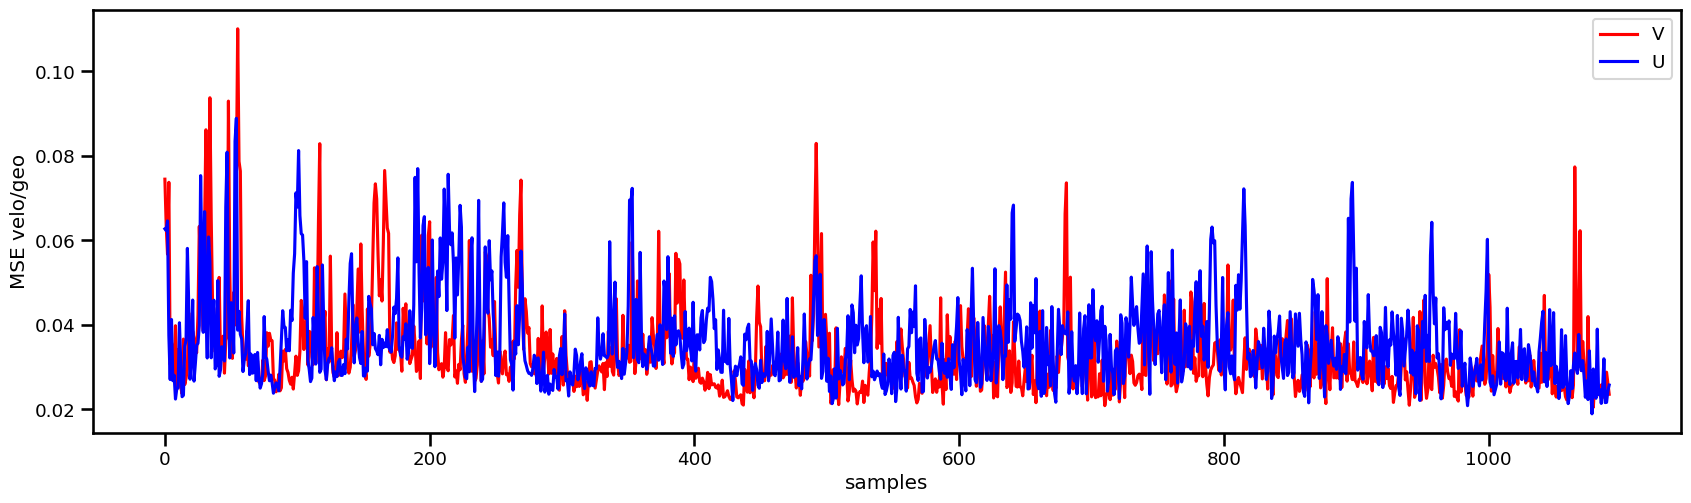

In [6]:
plt.rcParams["figure.figsize"] = [20.50, 5.50]
plt.plot(v_err,'r',u_err,'b')
plt.ylabel('MSE velo/geo')
plt.xlabel('samples')
plt.gca().legend(('V','U'))
plt.show()


## Learning from Geostrophic current.


In [15]:
class sim:
    def __init__(self, name, tloss, vloss, bloss):
        self.name  = name
        self.tloss = tloss
        self.vloss = vloss
        self.bloss = bloss
        
simulations={'2conv_uv','2conv_uv2','2conv_uv_dxy_2', '2conv_uv2_dxy', 'res_uv', 'res_uv_dxy','2conv_guv','2conv_guv_dxy' }
data_path= '/home/anas/MEOM_Workspace/data/models/snapshot/UNet/'
sims=[]

for simulation in simulations:
    name=simulation
    #print(data_path + name + 'loss.txt')
    edata= pd.read_csv(data_path + name + '/loss.txt', sep=",")
    bdata= pd.read_csv(data_path + name + '/Bloss.txt')
    tloss=edata["train_loss"]
    vloss=edata["val_loss"]
    bloss=bdata
    #print(bloss.shape)
    sims.append(sim(name,tloss,vloss,bloss))

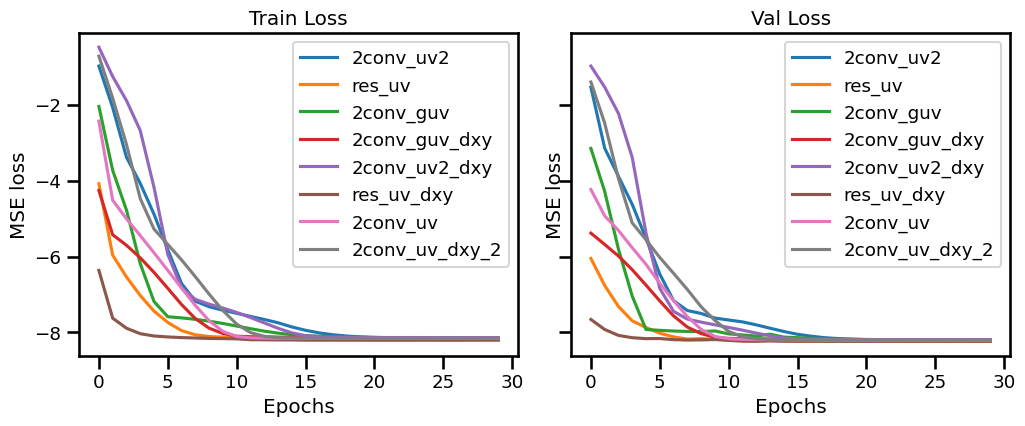

In [16]:
plt.rcParams["figure.figsize"] = [10.50, 4.50]
norm = 0.43405532837#sims[0].tloss.values[0]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
for sim in sims:
        ax1.plot(np.log(sim.tloss/norm),label=sim.name)
        ax2.plot(np.log(sim.vloss/norm),label=sim.name)

ax1.title.set_text('Train Loss')
ax1.set_ylabel('MSE loss')
ax1.set_xlabel('Epochs')
ax1.legend()

ax2.title.set_text('Val Loss')
ax2.set_ylabel('MSE loss')
ax2.set_xlabel('Epochs')
ax2.legend()            
plt.tight_layout()
plt.show()

9


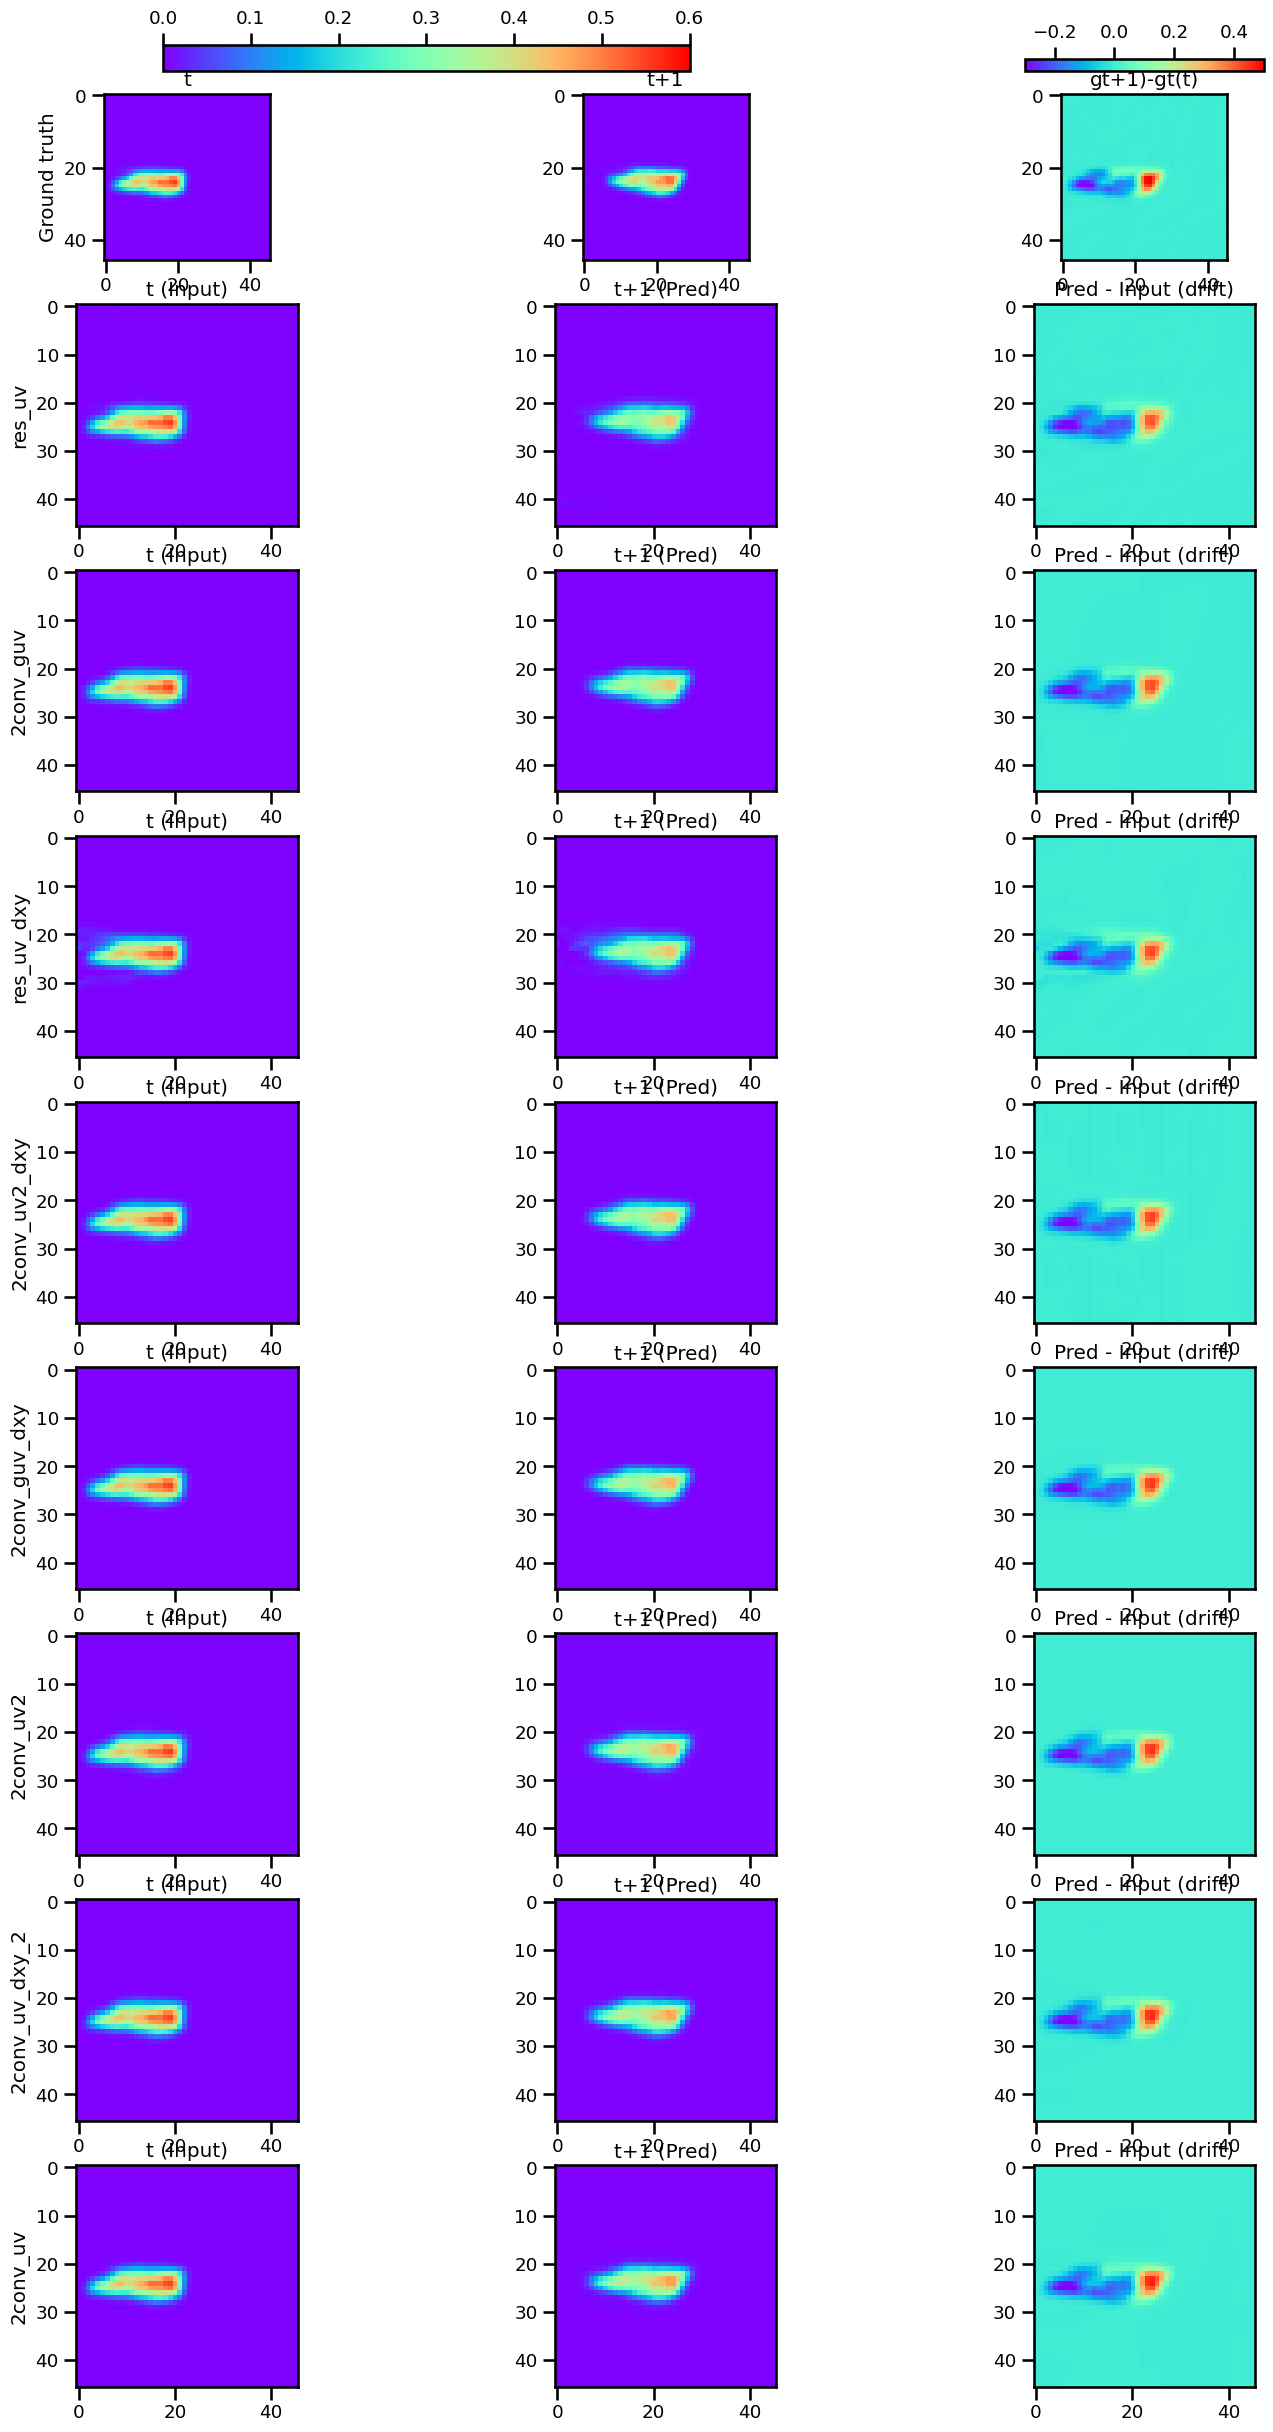

In [29]:
sims1=sims.copy()
sims1.insert(0,sims[0])
print(len(sims1))
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

j=10
file_in= data_path + sims1[0].name + '/maps.nc'
nc1 = xr.open_dataset(file_in)
x = nc1.density_map_gt.values[j,0,:,:]
ind = np.unravel_index(np.argmax(x, axis=None), x.shape)
#print([1:1:10])


plt.rcParams["figure.figsize"] = [17.50, 30.50]
#plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(len(sims1), 3)

""" Iterate column's axes"""
def iterate_columns(cols, x,ind,i, name):
    k=23
    mmax=0.6
    if i==0:
        
        
        im=cols[0].imshow(x.density_map_gt.values[j-1,0,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k], 
                       cmap=cm.rainbow, vmin=0, vmax=mmax)
        #fig.colorbar(im, ax=cols[0], location = "top")
        cols[0].title.set_text('t')
        cols[0].set_ylabel('Ground truth')
        cols[1].imshow(x.density_map_gt.values[j,0,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k],
                       cmap=cm.rainbow, vmin=0, vmax=mmax)
        cols[1].title.set_text('t+1')
        fig.colorbar(im, ax=cols[:2], shrink=0.6, location='top',pad=0.1)

        im=cols[2].imshow(x.density_map_gt.values[j,0,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k]
                       -x.density_map_gt.values[j-1,0,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k],
                       cmap=cm.rainbow, vmin=-0.3, vmax=0.5)
        cols[2].title.set_text('gt+1)-gt(t)')
        fig.colorbar(im, ax=cols[2], shrink=0.6, location='top',pad=0.1)

    else:
        cols[0].imshow(x.density_map_gt.values[j-1,0,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k],
                       cmap=cm.rainbow, vmin=0, vmax=mmax)
        cols[0].title.set_text('t (Input)')
        cols[0].set_ylabel(name)
        cols[1].imshow(x.density_map_ml.values[j+1,0,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k],
                        cmap=cm.rainbow, vmin=0, vmax=mmax)
        cols[1].title.set_text('t+1 (Pred)')
        cols[2].imshow(x.density_map_ml.values[j+1,0,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k]
                       -x.density_map_gt.values[j-1,0,ind[0]-k:ind[0]+k,ind[1]-k:ind[1]+k],
                        cmap=cm.rainbow, vmin=-0.3, vmax=0.5)
        cols[2].title.set_text('Pred - Input (drift)')
        

    
""" Iterate row's axes"""
i=0
for row in axes:
    file_in= data_path + sims1[i].name + '/maps.nc'
    nc1 = xr.open_dataset(file_in)
    nc1.density_map_ml.values[j+1,0,:,:]=nc1.density_map_ml.values[j+1,0,:,:]
    iterate_columns(row, nc1, ind, i, sims1[i].name)
    i=i+1
nc1 = xr.open_dataset(file_in)
x = nc1.density_map_ml.values[j,0,:,:]

plt.show()


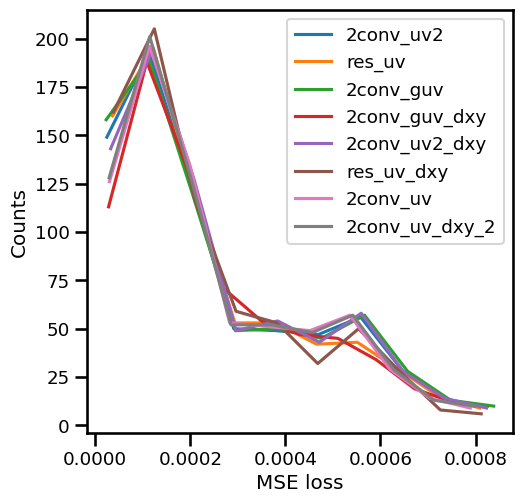

In [17]:
# histo of batches loss of the last epoch 
#f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
plt.rcParams["figure.figsize"] = [5.50, 5.50]
for sim in sims:
    bins,counts = np.histogram(sim.bloss/norm)
    plt.plot(counts[:-1],bins, label=sim.name)
    #print(sim.name)
plt.ylabel('Counts')
plt.xlabel('MSE loss')
plt.legend()

plt.show()

## Understanding the trainable parameters




```_________________________________________________________________________
Layer                  Type               Output Shape        Param #     RF
=============================================================================
convresidualnet          ConvResidualNet    (-1, 1, 366, 230)      0       5              
├─initial_layer          Conv2d             (-1, 1, 366, 230)      2       5              
|    └─0                 ConvResidualBlock  (-1, 1, 366, 230)      20      5              
├─final_layer            Conv2d             (-1, 1, 366, 230)      2       1              
============================================================================
Trainable params: 24 + n_input
Non-trainable params: 0
Total params: 24 + n_input


```




The following explain the table above:


n_trainable = N_input * N_output + 1 ( bias term); for each layer

```
{'net': ConvResidualNet(
  (initial_layer): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))             -----------> 1*1+1    = 2
  (blocks): ModuleList(
    (0): ConvResidualBlock(
      (conv_layers): ModuleList(
        (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))   -----------> 3*3+1   = 10
        (1): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))   -----------> 3*3+1   = 10
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (final_layer): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))               -------------> 1*1+1 = 2
)
                                                                                                      24 total
```                                                                                                  







